## Imports

In [9]:
import pandas as pd
import random
import numpy as np
from scipy.stats import poisson
from scipy.optimize import minimize
import seaborn as sns

# Premier League Projection

## Goals
The primary goal of this project is to leverage the provided xG (expected goals) data per game, pre-game probabilities of completed matches, and bookmakers' probabilities for upcoming games to forecast the outcome of the English Premier League (PL) 2023/2024 season. (As per the data, it has been played until Matchweek 11). 

The project aims to generate insights and predictions regarding each team's probability of finishing at every position within the league table (ranging from 1st to 20th), predict the likelihood of winning the title, determine the chances of securing a spot in the Top 4, and estimate the probability of relegation for the teams involved.

## Project Methodology
The Dixon-Coles model is famous for its power in setting the basis in football predictive analytics, by assuming that the goals scored by each team in a game adhere to a Poisson distribution. This distribution predicts the average number of goals a team might score based on their offensive and defensive capabilities. The model calculates these offensive and defensive parameters, denoted as α (offence) and β (defence), through a maximum likelihood estimation process, enabling the estimation of the average goals scored per game for each team.

The model introduces 2 improvements, the first one is adding a diagonal inflation to the model by adding a parameter called "rho" (ρ), which controls the correlation between home and away goals. This accounts for the observation that the occurrence of draws in soccer games is more frequent than predicted solely by the base model. The model acknowledges that teams' goal-scoring rates vary depending on factors like the current scoreline and time remaining in the match.

The second innovation, involves introducing a weighting factor for each game within the likelihood function. This modification, as detailed in the original paper, emphasizes the significance of recent games by assigning them greater weight in the model. In essence, it allows the model to factor in the influence of recent match outcomes more significantly than those that occurred further back in time.

By integrating these additional features into the basic Poisson-based framework, the Dixon-Coles model not only considers team-specific offensive and defensive capabilities but also adapts to the dynamic nature of soccer matches by accounting for the evolving influence of recent game outcomes on the assessment of a team's performance.

I will therefore be using a modified implementation of Dixon-Coles model with deserved goals, to generate team-strength parameters to get, for each match, the probabilities of a home win, a draw, or an away win. I will also introduce a small variation to the model to add further power to the model by making use of the pre-match probabilities given by bookmakers. Incorporating this data can enhance the predictive power of the model as Hvattum and Arntzen mention that "in general betting odds possess an excellent predictive quality and perform better in forecasting soccer results than various quantitative models." Hvattum and Arntzen H (2010) https://doi.org/10.1016/j.ijforecast.2009.10.002.

I will be using these probabilites with the implementation of ELO-Odds model from Wunderlich and Memmert (2018) https://doi.org/10.1371/journal.pone.0198668 with a slight variation so that the difference between best and worst teams does not get so big. I will use this ELOs ratings as a way to determine team strength paired with Dixon-Coles (DC) model strength parameters. 

I have tried numerous ways of adding these ELO rating so that it best reflects the power of the teams, without making the learned team strengths from Dixon-Coles irrelevant. By centering ELOs around 1, a team above the mean will see its strength parameters increased while a worse team with an ELO under 1 will see its values decreased. 

* I have tried adding the ELO difference as another parameter, i.e.: home_predicted = exp(α + β + γ + Elo_diff); away_predicted = exp(α+β-Elo_diff)
* I have tried multiplying each teams ELO rating to each DC parameter, i.e.: home_predicted = exp(α*hELO + β*aELO + γ); away_predicted = exp(α*hELO + β*aELO)

In the end I felt like these ones were adding too much importance to the ELO and were giving too much power to big teams, and making it almost impossible for worse teams to win games. 
* Therefore, I decided to simply multiply the predicted goals by the ELO, i.e.: home_predicted = exp(α + β + γ)*hELO; away_predicted = exp(α + β)*aELO

## Process Summary
* Generate current ELO-Odds rating for each team
* Finding team offensive, team defensive, rho correction and home advantage optimal parameters with DIxon-Coles and ELO-Odds and data from previous matches
* Generate probabilities for each result for the rest of the games with the learned parameters
* Simulating the score and outcome of all remaining matches 10000 times from the generated probabilities
* Getting the average final position for each team and the probabilities of each team finishing on each position, winning the league, ending on Champions spots (top4) or being relegated.

## Taking a look at the data

In [10]:
df = pd.read_excel('Alex Marin_Test1.xlsx',header=1)

df.head()

,wk,day,date,time,country,league_code,home_team,away_team,status,home_xG_SC,...,away_goals,home_points,away_points,xg_prob_draw,xg_prob_win,xg_prob_loss,home_deserved_goals,away_deserved_goals,home_deserved_points,away_deserved_points
0,1,Fri,2023-08-11,20:00 (00:00),England,ENG1,Burnley,Manchester City,completed,0.33,...,3.0,0.0,3.0,0.183552,0.050281,0.762722,0.0,1.0,0.33,2.47
1,1,Sat,2023-08-12,12:30 (16:30),England,ENG1,Arsenal,Nottingham Forest,completed,1.37,...,1.0,3.0,0.0,0.299972,0.246057,0.453700,0.0,1.0,1.04,1.66
2,1,Sat,2023-08-12,15:00 (19:00),England,ENG1,Everton,Fulham,completed,2.24,...,1.0,0.0,3.0,0.173157,0.609376,0.195991,2.0,1.0,2.00,0.76
3,1,Sat,2023-08-12,15:00 (19:00),England,ENG1,Sheffield United,Crystal Palace,completed,0.55,...,1.0,0.0,3.0,0.199662,0.088682,0.708209,0.0,1.0,0.47,2.32
4,1,Sat,2023-08-12,15:00 (19:00),England,ENG1,Brighton and Hove Albion,Luton Town,completed,3.45,...,1.0,3.0,0.0,0.101679,0.695768,0.091055,3.0,1.0,2.19,0.37


## ELO-Odds Rating

In [11]:
def update_ELO_Odds(ELO_ratings_df, index, match, c=10, d=400, k=175, home_advantage=80):
    """
    Updates the Elo ratings based on match outcomes probabilities and Elo ratings of teams. 
    Updates happen on the ELO_ratings_df and also stores the ELO before the match on the row from main dataset.

    Parameters
    -----------
    ELO_ratings_df : DataFrame
        DataFrame containing teams' Elo ratings and odds before the match.
    index : int
        Index of the match in the dataset.
    match : DataFrame row
        Row representing the match details (home_team, away_team, home_prob, draw_prob, away_prob).
    c : int, optional
        Constant value for the ELO-Odds model (default is 10).
    d : int, optional
        Constant value for the ELO-Odds model (default is 400).
    k : int, optional
        Adjustment factor for ELO ratings update (default is 175).
    home_advantage : int, optional
        Home advantage parameter (default is 80).

    Returns
    ----------
    None
    """
    # We get both home and away's team current ELO score and match probabilities (home, draw, away)
    home_team_idx = ELO_ratings_df[ELO_ratings_df['team']==match['home_team']].index[0]
    away_team_idx = ELO_ratings_df[ELO_ratings_df['team']==match['away_team']].index[0]
    ELO_home_before = ELO_ratings_df.iloc[home_team_idx,1]
    ELO_away_before = ELO_ratings_df.iloc[away_team_idx,1]
    home_prob = df.at[index, 'home_prob']
    draw_prob = df.at[index, 'draw_prob']

    # Calculate expected results based on Elo ratings and match probabilities
    expected_result_home = 1/(1 + c ** ((ELO_home_before - ELO_away_before - home_advantage) / d))
    expected_result_away = 1 - expected_result_home

    # Calculate actual result for home and away teams from match probabilities
    actual_result_home = home_prob + 0.5 * draw_prob
    actual_result_away = 1 - actual_result_home
    
    # Update home and away ELO ratings before the match centering them around 1 instead of 1000
    df.at[index, 'home_ELO'] = ELO_home_before/1000
    df.at[index, 'away_ELO'] = ELO_away_before/1000

    # Update ELO ratings based on actual and expected results using the ELO-Odds formula
    ELO_ratings_df.at[home_team_idx, 'ELO_odds'] += k * (actual_result_home-expected_result_home)
    ELO_ratings_df.at[away_team_idx, 'ELO_odds'] += k * (actual_result_away-expected_result_away)
    

## Dixon-Coles Model and Parameters Training

In [12]:
def rho_correction(x, y, lambda_x, mu_y, rho):
    """
    Applies the rho correction factor to adjust goal probabilities in the Dixon-Coles model for 0-0, 0-1, 1-0, 11 results.

    Parameters
    -----------
    x : int
        Goals scored by the home team.
    y : int
        Goals scored by the away team.
    lambda_x : float
        Expected goals scored by the home team.
    mu_y : float
        Expected goals scored by the away team.
    rho : float
        Correlation parameter in the Dixon-Coles model.

    Returns
    ----------
    float
        Adjusted probability based on the Dixon-Coles rho correction.
    """
    if x==0 and y==0:
        return 1 - (lambda_x * mu_y * rho)
    elif x==0 and y==1:
        return 1 + (lambda_x * rho)
    elif x==1 and y==0:
        return 1 + (mu_y * rho)
    elif x==1 and y==1:
        return 1 - rho
    else:
        return 1.0
    
def solve_parameters_decay(dataset, xi=0.001, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    """
    Solves the parameters for the Dixon-Coles decay model using optimization techniques.

    Parameters
    -----------
    dataset : DataFrame
        DataFrame containing match data and relevant features.
    xi : float, optional
        Decay rate parameter for time weighting (default is 0.001).
    debug : bool, optional
        Indicates whether to show debugging information (default is False).
    init_vals : array-like, optional
        Initial values for model parameters (default is None).
    options : dict, optional
        Optimization options (default is {'disp': True, 'maxiter': 100}).
    constraints : list, optional
        Constraints for optimization (default is [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}]).
    kwargs : dict
        Additional keyword arguments for the optimization function.

    Returns
    ----------
    dict
        Dictionary containing the optimized model parameters for attack and defense strengths,
        rho (score correction), and gamma (home advantage).
    """
    teams = np.sort(dataset['home_team'].unique())
    n_teams = len(teams)
    if init_vals is None:
        # Random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)),               # Attack strength
                                      np.random.uniform(0,-1,(n_teams)),            # Defence strength
                                      np.array([0, 1.0])                            # Rho (score correction), Gamma (home advantage)
                                     ))
        
    def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, home_ELO, away_ELO, xi=0):
        """
        Calculates the log likelihood for the Dixon-Coles decay model.

        Parameters
        -----------
        x : int
            Goals scored by the home team.
        y : int
            Goals scored by the away team.
        alpha_x : float
            Attack strength for the home team.
        beta_x : float
            Defence strength for the home team.
        alpha_y : float
            Attack strength for the away team.
        beta_y : float
            Defence strength for the away team.
        rho : float
            Correlation parameter in the Dixon-Coles model.
        gamma : float
            Home advantage parameter.
        t : float
            Time difference between matches.
        home_ELO : float
            Elo rating of the home team before the match.
        away_ELO : float
            Elo rating of the away team before the match.
        xi : float, optional
            Decay rate parameter for time weighting (default is 0).

        Returns
        ----------
        float
            Log likelihood for the Dixon-Coles decay model.
        """
        lambda_x, mu_y = np.exp((alpha_x + beta_y + gamma)), np.exp((alpha_y + beta_x))
        lambda_x *= home_ELO
        mu_y *= away_ELO
        return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_params(params):
        """
        Estimates model parameters for the Dixon-Coles decay model.

        Parameters
        -----------
        params : array-like
            Model parameters representing attack and defense strengths for each team, rho, and gamma.

        Returns
        ----------
        float
            Negative sum of log-likelihood values for the Dixon-Coles decay model.
        """
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like_decay(row.home_goals, row.away_goals, score_coefs[row.home_team], defend_coefs[row.home_team],
                                score_coefs[row.away_team], defend_coefs[row.away_team], rho, gamma,
                                row.time_diff, row.home_ELO, row.away_ELO, xi=xi
                                ) for row in dataset.itertuples()]
        return -sum(log_like)
    
    opt_output = minimize(estimate_params, init_vals, options=options, constraints = constraints, **kwargs)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x)) 

## Predicting results

In [13]:
def dixon_coles_simulate_match(params_dict, home_team, away_team, max_goals=9):
    """
    Simulates a match using the Dixon-Coles model to predict the score matrix.

    Parameters
    -----------
    params_dict : dict
        Dictionary containing model parameters (attack, defense, home_adv) for teams.
    home_team : str
        Name of the home team.
    away_team : str
        Name of the away team.
    max_goals : int, optional
        Maximum number of goals considered (default is 9).

    Returns
    ----------
    numpy.ndarray
        Score matrix representing predicted goal distributions for the match.
    """

    home_ELO_before = ite_ELO_df[ite_ELO_df['team']==home_team]['ELO_odds'].iloc[0]/1000
    away_ELO_before = ite_ELO_df[ite_ELO_df['team']==away_team]['ELO_odds'].iloc[0]/1000
    team_avgs = [np.exp((params_dict['attack_'+home_team] + params_dict['defence_'+away_team] + params_dict['home_adv'])),
                 np.exp((params_dict['defence_'+home_team] + params_dict['attack_'+away_team]))]
    team_avgs[0] *= home_ELO_before
    team_avgs[1] *= away_ELO_before
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in team_avgs]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    correction_matrix = np.array([[rho_correction(home_goals, away_goals, team_avgs[0],
                                                   team_avgs[1], 0.3) for away_goals in range(2)] #params_dict['rho']
                                   for home_goals in range(2)])
    output_matrix[:2,:2] = output_matrix[:2,:2] * correction_matrix
    return output_matrix


def get_points(home_goals, away_goals):
    """
    Determines points awarded to both home and away teams based on the match outcome.

    Parameters
    -----------
    home_goals : int
        Number of goals scored by the home team.
    away_goals : int
        Number of goals scored by the away team.

    Returns
    ----------
    tuple
        Tuple containing points awarded to the home team and away team respectively.
    """

    if home_goals > away_goals:
        home_points, away_points = 3,0

    elif home_goals == away_goals:
        home_points, away_points = 1,1
        
    else:
        home_points, away_points = 0,3

    return home_points, away_points


def simulate_result(probs):
    """
    Simulates a match result based on provided probabilities of different score outcomes.  [[0-0,0-1,...,0-9],[1-0,1-1,...],...,[9-0,...]]

    Parameters
    -----------
    probs : numpy.ndarray
        Matrix of probabilities representing different score outcomes for a match.

    Returns
    ----------
    tuple
        Tuple containing the simulated number of goals scored by the home team and away team respectively.
    """

    probs = probs.flatten()                                             # Flatten the probability matrix as [0-0, 0-1, ..., 1-0, ..., 9-9]
    probs = probs/sum(probs)                                            # Normalize probabilities to ensure they sum up to 1
    possible_results = ["{:02d}".format(n) for n in range(100)]         # Match result to goals -> 00 = 0-0, 05 = 0-5, 50 = 5-0
    result = np.random.choice(possible_results, p=probs)                # Simulate a match result based on probabilities
    
    home_goals, away_goals = int(result[0]),int(result[1])

    return home_goals, away_goals


def simulate_future_matches(df, params):
    """
    Simulates future matches based on the Dixon-Coles model and updates the DataFrame with simulated outcomes.

    Parameters
    -----------
    df : pandas.DataFrame
        DataFrame containing upcoming matches data.
    params : dict
        Dictionary containing model parameters for the Dixon-Coles model.

    Returns
    ----------
    pandas.DataFrame
        Updated DataFrame with simulated match outcomes and probabilities.
    """
    future_matches_df = df[(df['status'] == 'upcoming')]
    for index, match in future_matches_df.iterrows():
        
        # Calculate probabilities for home win, draw, and away win
        probabilities = dixon_coles_simulate_match(params, match.home_team, match.away_team, max_goals=9)
        home_prob = list(map(lambda x:np.sum(np.tril(x, -1)), [probabilities]))[0]
        draw_prob = list(map(lambda x:np.sum(np.diag(x)), [probabilities]))[0]
        away_prob = list(map(lambda x:np.sum(np.triu(x, 1)), [probabilities]))[0]

        # Simulate match outcome and get points from resulting score
        home_goals, away_goals = simulate_result(probabilities)
        home_points, away_points = get_points(home_goals, away_goals)

        # Update DataFrame with simulated match outcomes and probabilities
        df.at[index, 'home_goals'], df.at[index, 'away_goals'] = home_goals, away_goals
        df.at[index, 'home_points'], df.at[index, 'away_points'] = home_points, away_points
        df.at[index, 'home_prob'] = home_prob
        df.at[index, 'draw_prob'] = draw_prob
        df.at[index, 'away_prob'] = away_prob

        # update_ELO_Odds(ite_ELO_df, index, match)
    
    return df

## Computing Final Standings

In [14]:
def compute_final_standings(df, i):
    """
    Computes final standings based on match results DataFrame for a specific iteration.

    Parameters
    -----------
    df : pandas.DataFrame
        DataFrame containing match results data.
    i : int
        Iteration number.

    Returns
    ----------
    pandas.DataFrame
        DataFrame containing computed final standings for teams.
    """
    # Create standings dataframe for iteration i
    standings_df = pd.DataFrame()

    # Compute Points
    standings_df['home_points'] = df[['home_team','home_points']].groupby('home_team').sum()
    standings_df['away_points'] = df[['away_team','away_points']].groupby('away_team').sum()
    standings_df['points'] = standings_df['home_points'] + standings_df['away_points']

    # Compute Wins
    standings_df['home_wins'] = df[['home_team','home_points']][df['home_points']==3].groupby('home_team').count()
    standings_df['away_wins'] = df[['away_team','away_points']][df['away_points']==3].groupby('away_team').count()
    standings_df['wins'] = standings_df['home_wins'].fillna(0) + standings_df['away_wins'].fillna(0)

    # Compute Draws
    standings_df['home_draws'] = df[['home_team','home_points']][df['home_points']==1].groupby('home_team').count()
    standings_df['away_draws'] = df[['away_team','away_points']][df['away_points']==1].groupby('away_team').count()
    standings_df['draws'] = standings_df['home_draws'].fillna(0) + standings_df['away_draws'].fillna(0)

    # Compute Losses
    standings_df['home_losses'] = df[['home_team','home_points']][df['home_points']==0].groupby('home_team').count()
    standings_df['away_losses'] = df[['away_team','away_points']][df['away_points']==0].groupby('away_team').count()
    standings_df['losses'] = standings_df['home_losses'].fillna(0) + standings_df['away_losses'].fillna(0)
    
    # Compute Goals For
    standings_df['home_goalsF'] = df[['home_team','home_goals']].groupby('home_team').sum()
    standings_df['away_goalsF'] = df[['away_team','away_goals']].groupby('away_team').sum()
    standings_df['goalsF'] = standings_df['home_goalsF'] + standings_df['away_goalsF']

    # Compute Goals Against
    standings_df['home_goalsA'] = df[['home_team','away_goals']].groupby('home_team').sum()
    standings_df['away_goalsA'] = df[['away_team','home_goals']].groupby('away_team').sum()
    standings_df['goalsA'] = standings_df['home_goalsA'] + standings_df['away_goalsA']

    # Compute Goal Difference
    standings_df['goalDiff'] = standings_df['goalsF'] - standings_df['goalsA']

    # Create simplified standings sorting by Premier League standards
    standings_df = standings_df.sort_values(['points', 'goalDiff','goalsF'],ascending=False).fillna(0)
    standings_df = standings_df.drop(list(standings_df.filter(regex='_')), axis=1).reset_index()        # Drop columns specific for home/away
    standings_df.index = standings_df.index+1                                                           # Make index indicate final position (1-20)
    standings_df.reset_index(drop=False, names='position', inplace=True)

    # Add iteration number
    standings_df['iteration'] = i+1

    return standings_df

## Get final simulation results

In [15]:
def add_final_positions(simp_standings_df):
    """
    Adds final positions to the final_results_df based on standings from one iteration.

    Parameters
    -----------
    simp_standings_df : pandas.DataFrame
        DataFrame containing simplified standings data for teams.

    Returns
    ----------
    None
    """
    # We add the results from one iteration to the final_results_df
    position_count = 1
    for team in simp_standings_df['home_team']:
        final_results_df[position_count][team] += 1
        position_count += 1


def get_final_results_probabilities(final_results_df, final_standings_df, num_iterations):
    """
    Computes probabilities based on final results and standings from multiple iterations.

    Parameters
    -----------
    final_results_df : pandas.DataFrame
        DataFrame containing final results data.
    final_standings_df : pandas.DataFrame
        DataFrame containing final standings data.
    num_iterations : int
        Total number of iterations.

    Returns
    ----------
    tuple
        Tuple containing aggregated standings DataFrame with probabilities and DataFrame with team-wise probabilities.
    """
    final_agg_standings_df = final_standings_df.groupby(['home_team']).mean().drop('iteration',axis=1)                  # Compute average standings from final standings DataFrame
    final_results_probs_df = (final_results_df / num_iterations)*100                                                    # Compute probabilities from final results DataFrame based on the number of iterations

    # Add the avg position and manipulate DataFrames to compute specific probabilities and order teams accordingly
    final_results_probs_df = final_results_probs_df.merge(final_agg_standings_df['position'],
                                                          left_on=final_results_probs_df.index,
                                                          right_on=final_agg_standings_df.index)\
                                                    .sort_values('position')\
                                                    .drop('position',axis=1)\
                                                    .rename({'key_0':'Team'},axis=1)\
                                                    .set_index('Team')                                                  

    # Calculate additional probabilities like Champion, Top 4, and Relegation
    final_agg_standings_df['Champion'] = final_results_probs_df[1]
    final_agg_standings_df['Top 4'] = final_results_probs_df.loc[:,1:4].sum(axis=1)
    final_agg_standings_df['Relegation'] = final_results_probs_df.iloc[:,-3:].sum(axis=1)

    # Sort aggregated standings DataFrame based on specific criteria
    final_agg_standings_df = final_agg_standings_df.sort_values(['position','points','goalDiff','Champion','Top 4','Relegation'], ascending=[True, False, False, False, False, True])

    return final_agg_standings_df, final_results_probs_df

## Main

In [16]:
"""
Main function to run the simulation and analysis for league matches.

Reads data, initializes parameters, computes team strengths using ELO-Odds model,
trains Dixon-Coles model parameters, simulates future matches, and aggregates final standings.

Returns
----------
pandas.DataFrame
    DataFrame containing aggregated final standings and probabilities.
"""
# We import the data into a pandas dataframe
df = pd.read_excel('Alex Marin_Test1.xlsx',header=1)
df.drop(['day','time','country','league_code','home_xG_SC','away_xG_SC','home_xG_BP','away_xG_BP','score'],axis=1,inplace=True)
df['time_diff'] = (max(df['date']) - df['date']).dt.days

# We create a list of the teams
teams_list = df['home_team'].unique()
teams_list.sort()

# Initialise ELO rating scores to 1000 for all teams
ELO_ratings_df = pd.DataFrame({'team':teams_list,'ELO_odds':1000}) 

# Set the parameters for ELO-Odds model (Hvattum and Arntzen (2010) reported that c = 10 and d = 400 is sufficient.)
c = 10
d = 400
k = 50                                  # Adjustment factor (Wunderlich and Memmert (2018) reported that k=175 and ω=80 -- ) -> I reduced the value k so that the difference between top and bottom teams is not so big
home_advantage = 100                    # Home advantage ω

# We get the training dataset for ELO-Odds made of the already completed matched
completed_matches_df = df[df['status'] == 'completed']

# We compute the current team strength by running ELO-Odds model for completed matches
for index, match in completed_matches_df.iterrows():
    update_ELO_Odds(ELO_ratings_df, index, match, c, d, k, home_advantage)

# We get the completed matches data together with the updated ELOs for each match and create the dataframe to train the Dixon-Coles parameters
completed_matches_ELO_df = df[df['status'] == 'completed']
train_df = completed_matches_ELO_df[['home_team','away_team','home_deserved_goals','away_deserved_goals','home_ELO','away_ELO','time_diff']]\
                .rename(columns={'home_deserved_goals':'home_goals','away_deserved_goals':'away_goals'})

# Solving Dixon-Coles model parameters
params = solve_parameters_decay(train_df, xi=0.00325)
print(params)   # Displaying trained parameters from the Dixon-Coles model

# We initialise the table to store the final standings from all the iterations and all the points, goals, ...
final_results_df = pd.DataFrame(0, columns=list(range(1, 21)), index=teams_list)
final_standings_df = pd.DataFrame({})

num_iterations = 10000   # Number of simulations of the remaining matches of the league

# Iterating through multiple simulations of the remaining matches of the league and aggregating standings
for i in range(num_iterations):
    
    ite_ELO_df = ELO_ratings_df.copy()
    simulated_df = simulate_future_matches(df, params)
    ite_standings_df = compute_final_standings(simulated_df, i)
    final_standings_df = pd.concat([final_standings_df,ite_standings_df])           # Adding the new iteration to the total
    add_final_positions(ite_standings_df)                                           # Adding the final positions to the total

# Aggregating final standings and calculating probabilities
final_agg_standings_df, final_results_probs_df = get_final_results_probabilities(final_results_df, final_standings_df, num_iterations)

C:\Users\Alex\AppData\Local\Temp\ipykernel_3756\1842960412.py:110: RuntimeWarning: invalid value encountered in log
  return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))
C:\Users\Alex\AppData\Local\Temp\ipykernel_3756\1842960412.py:110: RuntimeWarning: divide by zero encountered in log
  return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 106.53169472417082
            Iterations: 25
            Function evaluations: 1102
            Gradient evaluations: 25
{'attack_Arsenal': 1.172298262274551, 'attack_Aston Villa': 1.3687098102657025, 'attack_Bournemouth': 0.7400731233787884, 'attack_Brentford': 1.3480851195232784, 'attack_Brighton and Hove Albion': 1.3228382414610718, 'attack_Burnley': 0.5453398861688993, 'attack_Chelsea': 1.5341208680798142, 'attack_Crystal Palace': 0.46545788414321476, 'attack_Everton': 0.9630406986012829, 'attack_Fulham': 0.41363101574920347, 'attack_Liverpool': 1.709743879535246, 'attack_Luton Town': 0.7222222130604057, 'attack_Manchester City': 1.1997091817425047, 'attack_Manchester United': 0.8204931913402148, 'attack_Newcastle United': 1.5950810258944024, 'attack_Nottingham Forest': 0.4009861734399749, 'attack_Sheffield United': 0.037185007126026695, 'attack_Tottenham Hotspur': 1.2625503506241762, 'attack

## Results

In the results below we can see the model does quite a good job regarding overall final positions and points. However, it is worth mentioning that Newcastle is a bit further up than was maybe expected. Also Manchester United seems to be very undervalued by the model, given a very poor final position and amount of points. Also I think, last position Sheffield is projected to have too few points and should be closer to the 19th spot. Newcastle's strength parameters are being inflated by a very good goal difference at the start of the season while Manchester United, has otherwise underperformed based on what was expected and therefore the model has a hard time predicting their final position.. I believe by adding ELO-Odds this over/underperformance by teams can be compensated a little bit and help it find more realistic strengths. 

In terms of goals, the model does a pretty decent job in capturing Goal differences in my opinion. However, it struggles to find the accurate balance for Goals for and Goals Against. I believe Manchester City should be making quite a lot more goals and receiving some more. Although they may be the strongest team on defense, it seems unreasonable to think they are only going to concede 10 goals. On the opposite side of the table, again Sheffield is projected to have too few goals made and too many conceded ones.

In conclusion, although the model is far from perfect and can definitely improve, I think it does a reasonably good job on predicting the final positions of each team this season.

In [17]:
# Display the final aggregated average standings and team-wise probabilities
display(final_agg_standings_df.round(1)), display(final_results_probs_df.astype(int))

,position,points,wins,draws,losses,goalsF,goalsA,goalDiff,Champion,Top 4,Relegation
home_team,,,,,,,,,,,
Manchester City,1.6,88.2,26.7,8.1,3.2,62.1,10.7,51.4,62.4,99.8,0.0
Liverpool,2.7,82.1,25.0,7.1,5.9,77.9,26.5,51.4,16.8,91.8,0.0
Newcastle United,2.9,81.8,24.8,7.2,5.9,73.4,19.7,53.7,13.0,91.2,0.0
Arsenal,3.5,79.5,23.0,10.5,4.5,55.0,17.1,37.9,7.2,82.6,0.0
Chelsea,5.4,71.1,20.8,8.6,8.5,58.8,24.1,34.7,0.4,20.6,0.0
Aston Villa,6.3,67.7,20.4,6.4,11.2,61.2,37.9,23.3,0.2,8.6,0.0
Brighton and Hove Albion,7.4,63.6,18.3,8.7,11.0,57.3,41.2,16.1,0.0,2.4,0.0
Tottenham Hotspur,7.5,63.3,18.7,7.2,12.1,52.7,43.3,9.4,0.0,2.6,0.0
Brentford,8.9,57.1,15.8,9.6,12.6,50.6,39.5,11.1,0.0,0.4,0.0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Team,,,,,,,,,,,,,,,,,,,,
Manchester City,62,22,12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Liverpool,16,29,28,17,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Newcastle United,13,28,29,20,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arsenal,7,17,21,36,11,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Chelsea,0,1,5,13,35,25,12,6,0,0,0,0,0,0,0,0,0,0,0,0
Aston Villa,0,0,1,6,20,29,21,11,6,1,0,0,0,0,0,0,0,0,0,0
Brighton and Hove Albion,0,0,0,1,10,13,28,23,13,4,3,0,0,0,0,0,0,0,0,0
Tottenham Hotspur,0,0,0,2,8,17,21,25,15,8,1,0,0,0,0,0,0,0,0,0
Brentford,0,0,0,0,1,4,10,19,31,18,9,4,0,0,0,0,0,0,0,0


(None, None)

<Axes: ylabel='Team'>

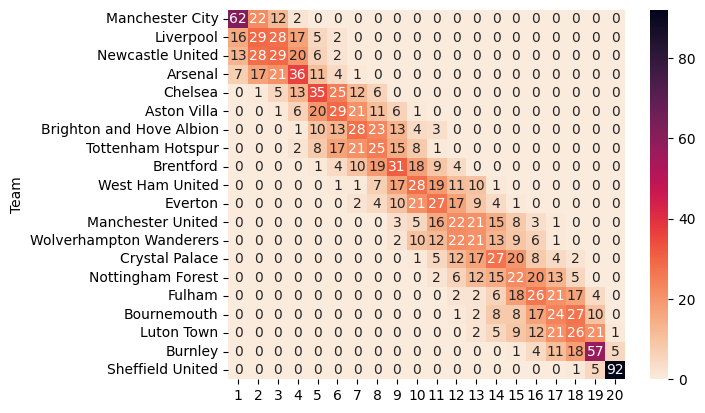

In [18]:
# Plotting the heatmap for final results probabilities
sns.heatmap(final_results_probs_df.astype(int),annot=True, cmap=sns.cm.rocket_r)